In [1]:
import librosa
import numpy as np
import sounddevice as sd
import matplotlib.pyplot as plt
import time

/home/hesham/.local/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


## Load Audio

In [2]:
y, sr = librosa.load("sd.mp3")
print(y.shape, sr)

/home/hesham/.local/lib/python3.6/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


(4720896,) 22050


In [3]:
sd.play(y, sr)
time.sleep(5)
sd.stop()

## Exploration

### Convert

In [4]:
spect_pw = librosa.feature.melspectrogram(y=y, sr=sr,n_fft=2048, hop_length=512, n_mels=3)
spect_db = librosa.power_to_db(spect_pw, ref=np.max)

In [5]:
spect_pw.shape

(3, 9221)

In [6]:
spect_db.shape

(3, 9221)

In [7]:
def normalize(x):
    x_min = x.min(axis=(0, 1), keepdims=True)
    x_max = x.max(axis=(0, 1), keepdims=True)

    return x/x_min

def spect_to_img(s, w=50):
    cutoff = w * w
    img = spect_db[:, :cutoff].transpose().reshape(w, w, -1)
    return normalize(img)

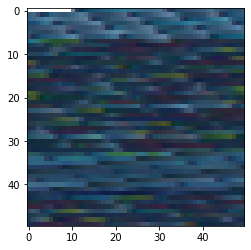

In [8]:
img = spect_to_img(spect_db)

plt.imshow(img)

### Convert back

In [9]:
mel_db = (img * -80).reshape(2500, -1).transpose()
mel = librosa.db_to_power(mel_db)
s = librosa.feature.inverse.mel_to_stft(mel)
print(s.shape)
t = librosa.griffinlim(s)
sd.play(t)
time.sleep(2)
sd.stop()

(1025, 2500)


Horrible quality!

## Better Conversion Logic

It seems that 128 is minimal for decent quality. 129 guaruantees we can encode the result into 3 layers (i.e. RGB).

In [10]:
def audio_to_mdb(t, sr, n_m=129):
    mpw = librosa.feature.melspectrogram(y=t, sr=sr,n_fft=2048, hop_length=512, n_mels=n_m)
    mdb = librosa.power_to_db(mpw, ref=np.max)
    return mdb

def mdb_to_audio(mdb):
    mpw = librosa.db_to_power(mdb)
    mel_inv = librosa.feature.inverse.mel_to_stft(mpw)
    t = librosa.griffinlim(mel_inv)
    return t

Let's test that process with a few seconds of audio

In [11]:
y_short = y[sr*30:sr * 35]
mdb = audio_to_mdb(y_short, sr)

In [12]:
sd.play(mdb_to_audio(mdb), sr)

In [13]:
def mdb_to_img(mdb):
    a = mdb.transpose().reshape((-1, 3)).copy()
    p = int(np.ceil(np.sqrt(a.shape[0])))
    a.resize(p*p*3)
    b = a.reshape((p,p,3))
    i = b / -80
    return i

def img_to_mdb(i, m_n=129):
    b = i * -80
    a = b.reshape((-1)).copy()
    a.resize(a.shape[0] - a.shape[0] % m_n)
    a = a.reshape((-1, 3))
    mdb = a.reshape((-1, m_n)).transpose()
    return mdb

In [14]:
test = np.arange(30).reshape((6, -1))
ti = mdb_to_img(test)
t_rev = img_to_mdb(ti, 6)
print(test)
print(ti*-80)
print(t_rev)

[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]
 [25 26 27 28 29]]
[[[ 0.  5. 10.]
  [15. 20. 25.]
  [ 1.  6. 11.]
  [16. 21. 26.]]

 [[ 2.  7. 12.]
  [17. 22. 27.]
  [ 3.  8. 13.]
  [18. 23. 28.]]

 [[ 4.  9. 14.]
  [19. 24. 29.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]

 [[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]]
[[ 0.  1.  2.  3.  4.  0.  0.  0.]
 [ 5.  6.  7.  8.  9.  0.  0.  0.]
 [10. 11. 12. 13. 14.  0.  0.  0.]
 [15. 16. 17. 18. 19.  0.  0.  0.]
 [20. 21. 22. 23. 24.  0.  0.  0.]
 [25. 26. 27. 28. 29.  0.  0.  0.]]


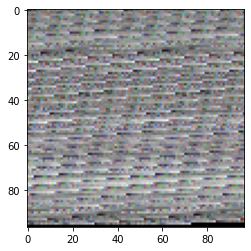

In [15]:
img = mdb_to_img(mdb)
plt.imshow(img)

In [16]:
rev_mdb = img_to_mdb(img)
rev_t = mdb_to_audio(rev_mdb)

sd.play(rev_t, sr)

Much better!

Volume should be adjusted based on amplitude range so mdb should contain that info.